<a href="https://colab.research.google.com/github/shami00122/peristalsis_system_09_08/blob/main/2022_09_08_%E4%BB%AE%E8%AA%AC2_%E6%94%B9%E8%89%AF_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデル定義

##シュミレーションのパラメータの定義

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

rng = np.random.default_rng()

a=1
b0=0.15
b2=0.2
b4=1
c=3
du0 = 1
du4 = 1

def setparameter():
  global A0
  global A2
  global A4
  global I
  global J
  A0 = 2
  A2 = 2
  A4 = 2
  I = -0.05
  J = 0

setparameter() 

simulationLength =100
systemSize = 100
#物理量パラメータの設定

correlation_loop_number = 3


dt=0.025
dx =1
outputStep = 400
loop = int(simulationLength/dt/outputStep)
n = int(systemSize/dx)

u = np.zeros((outputStep,6,n))

#シミュレーションパラメータの設定

##反応項の定義

In [ ]:
from IPython.core.display import JSON
def f(u):
  return np.array([
          10*(u[0]*(A0-u[0])*(u[0]-b0)-u[1] + I*u[2]),
          (u[0]-a*u[1]),
          10*(u[2]*(A2-u[2])*(u[2]-b2)-u[3])/5,
          (u[2]-a*u[3])/5,
          10*(u[4]*(A4-u[4])*(u[4]-b4)-u[5] + J*u[2]),
          (u[4] -a*u[5])
  ])
#1行４列のベクトル
#反応項
#配列としてreturnしている
#12行が輪走筋、34行が神経、56行が縦走筋

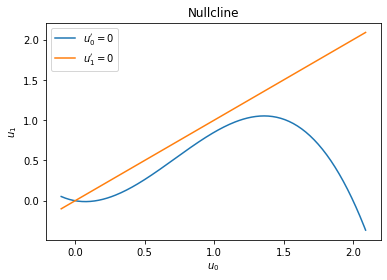

In [ ]:
uu = np.arange(-0.1,2.1,0.01)
#-0.1から2.1まで間隔0.01の配列ndarray
plt.plot(uu,uu*(A0-uu)*(uu-b0),label="$u_0'=0$")
plt.plot(uu, uu/a, label="$u_1'=0$")
plt.title("Nullcline")
plt.xlabel('$u_0$')
plt.ylabel('$u_1$')
plt.legend(loc = 2)
plt.show()
#ヌルクラインの確認
#
#平衡点が0.0（安定平衡点）

##空間相互作用の定義

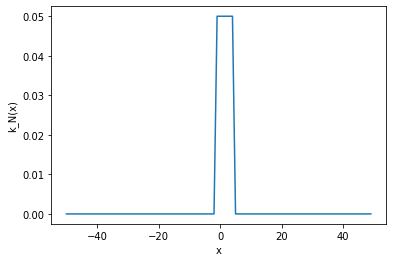

In [ ]:
r=3
d=2
r_n = int(r/dx)
d_n = int(d/dx)
s=0.05
n2 = int(n/2)

kernel_N = np.zeros(n)
kernel_N[:r_n + d_n]=s*dx
#kernel配列中のr+ｄ(=4)より小さい値までの配列 = s (=0.1)
kernel_N[-(r_n - d_n):]=s*dx
#kernel配列中の-(r-d)(=-2)より小さい値までの配列 = s (=0.1)
#kernel[0] = -s*(2*r-1)
#kernel配列中の初めの値を　-s*(2*r-1)
x = np.arange(-n2,n2)
plt.plot(x, np.roll(kernel_N, n2))
plt.xlabel('x')
plt.ylabel('k_N(x)')
#kernelの表示

def convolution(input, kernel):
  output = np.zeros(n)
  for x in range(n):
    output = output + input[x] * np.roll(kernel, x)
  return output  
#convolutionの定義


Text(0, 0.5, 'k_L(x)')

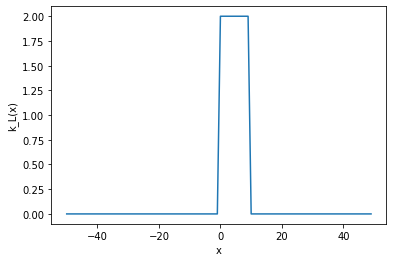

In [ ]:
r=10
r_n = int(r/dx)
s=2
n2 = int(n/2)

#縦走筋のkernel

kernel_L = np.zeros(n)
kernel_L[:r_n]=s*dx
#kernel配列中のr+ｄ(=4)より小さい値までの配列 = s (=0.1)
#kernel配列中の-(r-d)(=-2)より小さい値までの配列 = s (=0.1)
#kernel[0] = -s*(2*r-1)
#kernel配列中の初めの値を　-s*(2*r-1)
x = np.arange(-n2,n2)
plt.plot(x, np.roll(kernel_L, n2))
plt.xlabel('x')
plt.ylabel('k_L(x)')
#kernelの表示

##数値計算の関数

In [ ]:
def diffusion(u):
  return np.array(
      [
       dt * du0/dx/dx* (np.roll(u[0],1) + np.roll(u[0],-1) - 2*u[0]),
       u[1] * 0,
       dt *convolution(u[2], kernel_N),
       u[3] * 0,
       dt * du4/dx/dx* (np.roll(u[4],1) + np.roll(u[4],-1) - 2*u[4]) + dt * convolution(u[2], kernel_L),
       u[5] * 0
      ])
#拡散の定義、配列で返す

In [ ]:
def RungeKutta(u):
  k1 = f(u)
  k2 = f(u+1/2*k1*dt)
  k3 = f(u+1/2*k2*dt)
  k4 = f(u+k3*dt)
  return (k1+2*k2+2*k3+k4)/6

#拡散項の計算、グラフで確認した  

In [ ]:
noiseCutOffLength = 10
zeroVector = np.zeros(n)

def lowPassNoise():
  n1 = rng.random((n))
  n1f = np.fft.rfft(n1)
  n1f[int(noiseCutOffLength/dx):]=0
  n2 = np.fft.irfft(n1f)
  return n2-0.5


##結果の解析の関数（相関）

In [ ]:
def pearson(ds,ac):
    T=ac.size

    mu_ds = np.mean(ds)
    mu_ac = np.mean(ac)

    sigma_ds = np.std(ds)
    sigma_ac =np.std(ac)

    rho = -1/(T-1) * np.sum(
        (ds - mu_ds)/sigma_ds*(ac-mu_ac)/sigma_ac)
    return rho

##可視化の関数

In [ ]:

def uplot(u):
  fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=(9, 6))
  for j in range(3):
    for i in range(2):
      axes[i,j].imshow(u[:,i+j*2,:].T, vmin=-1, vmax=2, cmap = 'gray_r')
      axes[i,j].set_title("u"+str(i+j*2))
      axes[i,j].set_xlabel('t')
      axes[i,j].set_ylabel('x')
      axes[i,j].set_aspect(1./axes[i,j].get_data_ratio())

In [ ]:
def muscle_contraction_plot(u):
  fig, axes = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
  axes.imshow((u[:,0,:]-u[:,4,:]).T, vmin=-10, vmax=10, cmap = 'gray_r')
  axes.set_title("u0-u4")
  axes.set_xlabel('t')
  axes.set_ylabel('x')
  axes.set_aspect(1./axes.get_data_ratio())

#実際の数値計算

## E12

In [ ]:
for t in tqdm(range(outputStep-1)):
  
  noiseMatrix = np.array([2*lowPassNoise(),
                        zeroVector,
                        zeroVector,
                        zeroVector,
                        zeroVector,
                        zeroVector])
  for j in range(loop):
    
    u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
    
    u[t]=u[t+1]

100%|██████████| 399/399 [00:30<00:00, 12.92it/s]


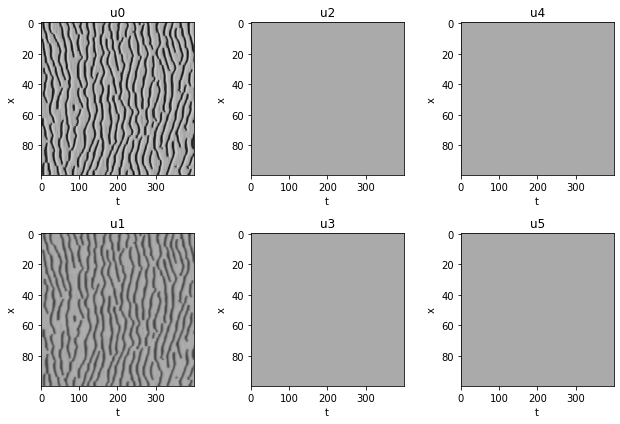

In [ ]:
uplot(u)

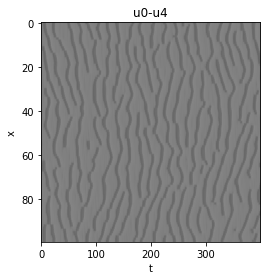

In [ ]:
muscle_contraction_plot(u)

## E16

### control

In [ ]:
setparameter()
for t in tqdm(range(outputStep-1)):
  
  noiseMatrix = np.array([2*lowPassNoise(),
                        zeroVector,
                        0.5*lowPassNoise(),
                        zeroVector,
                        zeroVector,
                        zeroVector])
  for j in range(loop):
    
    u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
    
    u[t]=u[t+1]

100%|██████████| 399/399 [00:25<00:00, 15.85it/s]


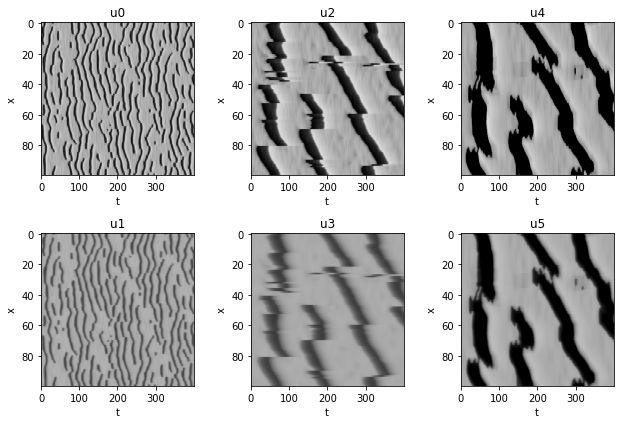

In [ ]:
uplot(u)

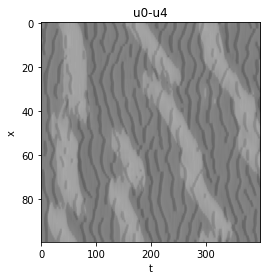

In [ ]:
muscle_contraction_plot(u)

In [ ]:
def cal():  
  for t in range(outputStep-1):
    
    noiseMatrix = np.array([lowPassNoise(),
                          zeroVector,
                          0.3*lowPassNoise(),
                          zeroVector,
                          lowPassNoise(),
                          zeroVector])
    for j in range(loop):
      
      u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
      u[t]=u[t+1]

  avr = 0
  for i in range(n):  
    avr += pearson(u[:,0,i], u[:,4,i])

  return (avr/n)

In [ ]:
pearson_data_control = []
for i in range(correlation_loop_number):
  pearson_data_control += [cal()]
  print(i)
print(pearson_data_control)

0
1
2
[0.09285328487244819, 0.008627726514621525, 0.010286906728205607]


### 薬剤刺激


#### NO

In [ ]:
setparameter()
A0 = 1.5
A2 = 2
A4 = 1.5

In [ ]:
for t in tqdm(range(outputStep-1)):
  
  noiseMatrix = np.array([2*lowPassNoise(),
                        zeroVector,
                        0.5*lowPassNoise(),
                        zeroVector,
                        zeroVector,
                        zeroVector])
  for j in range(loop):
    
    u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
    
    u[t]=u[t+1]

100%|██████████| 399/399 [00:19<00:00, 20.93it/s]


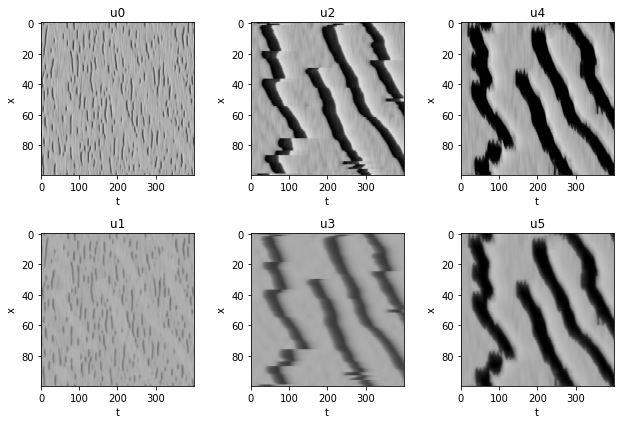

In [ ]:
uplot(u)

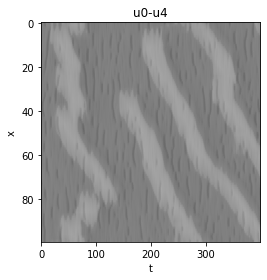

In [ ]:
muscle_contraction_plot(u)

#### NOLA

In [ ]:
setparameter()
A0 = 2.25
A2 = 2
A4 = 2.25

In [ ]:
for t in tqdm(range(outputStep-1)):
  
  noiseMatrix = np.array([2*lowPassNoise(),
                        zeroVector,
                        0.5*lowPassNoise(),
                        zeroVector,
                        zeroVector,
                        zeroVector])
  for j in range(loop):
    
    u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
    
    u[t]=u[t+1]

100%|██████████| 399/399 [00:18<00:00, 21.86it/s]


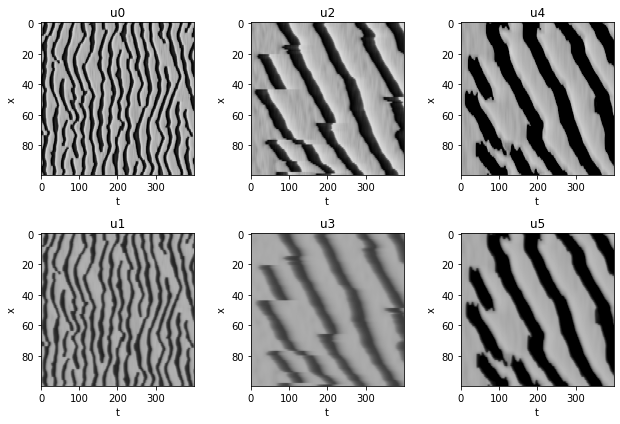

In [ ]:
uplot(u)

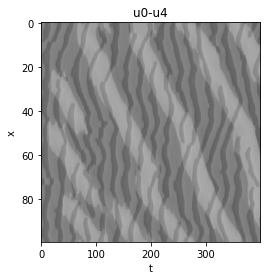

In [ ]:
muscle_contraction_plot(u)

#### TTX

In [ ]:
setparameter()
I = -0.1 * 0.5
J = 0.4 * 0.5

In [ ]:
pearson_data_TTX = []
for i in range(correlation_loop_number):
  pearson_data_TTX += [cal()]
  print(i)
print(pearson_data_TTX)

0
1
2
[0.1192550951584417, -0.007230387889013814, 0.04763756538527295]


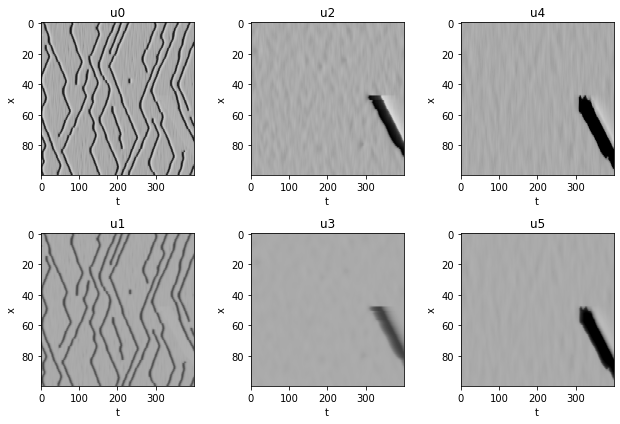

In [ ]:
uplot(u)

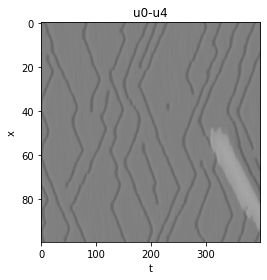

In [ ]:
muscle_contraction_plot(u)

#### SNP

In [ ]:
setparameter()
A0 = 1.5
A2 = 2
A4 = 1.5

In [ ]:
pearson_data_SNP = []
for i in range(correlation_loop_number):
  pearson_data_SNP += [cal()]
  print(i)
print(pearson_data_SNP)

0
1
2
[0.17186159474628712, 0.1538341744855032, 0.0515738747542096]


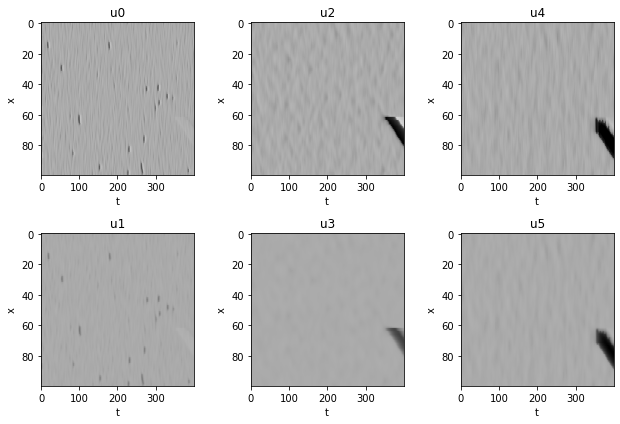

In [ ]:
uplot(u)

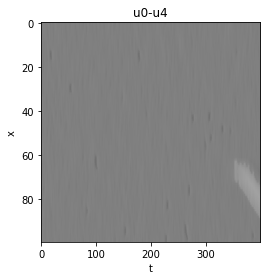

In [ ]:
muscle_contraction_plot(u)

###縦走筋と輪走筋の相関

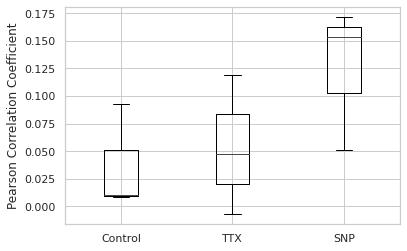

In [ ]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')

np.random.seed(2018)

x1 = pearson_data_control
x2 = pearson_data_TTX
x3 = pearson_data_SNP

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot([x1, x2, x3], labels=['Control', 'TTX', 'SNP'])
ax.set_ylabel('Pearson Correlation Coefficient')
plt.show()

In [ ]:
import pandas as pd

data = pd.DataFrame({
    'Control' : pearson_data_control,
    'TTX' : pearson_data_TTX,
    'SNP' : pearson_data_SNP,
})

In [ ]:
from scipy import stats
fvalue, pvalue = stats.f_oneway(data['Control'], data['TTX'], data['SNP'])
print(f"F-val:{fvalue:.4},  P-val:{pvalue:.4}")

F-val:1.898,  P-val:0.2298


In [ ]:
data_melt = data.melt(var_name='Experiment', value_name='CorrCoef')
data_melt

,Experiment,CorrCoef
0,Control,0.092853
1,Control,0.008628
2,Control,0.010287
3,TTX,0.119255
4,TTX,-0.007230
5,TTX,0.047638
6,SNP,0.171862
7,SNP,0.153834
8,SNP,0.051574


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pairwise_tukeyhsd(data_melt["CorrCoef"], data_melt["Experiment"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Control,SNP,0.0885,0.239,-0.0599,0.2369,False
Control,TTX,0.016,0.9,-0.1324,0.1644,False
SNP,TTX,-0.0725,0.3564,-0.2209,0.0759,False


### 物理刺激

In [ ]:
wavenumber = 6
u0 = np.sin(np.arange(0,6.28*wavenumber,6.28*wavenumber/n))
#6.28は2π
u1 = np.roll(u0,-5)
#roll...u0の配列を左に５ずらす

In [ ]:
u = np.zeros((outputStep,6,n))

u[0,0] = u0
u[0,1] = u1
#u[0,0,50:60]=0.3
#u[0,1,55:65]=0.1
#u[0,2,50:60]=0.3
#u[0,3,55:65]=-0.1
#初期値の設定 全部0にする

noiseCutOffLength = 10

def lowPassNoise():
  n1 = rng.random((n))
  n1f = np.fft.rfft(n1)
  n1f[int(noiseCutOffLength/dx):]=0
  n2 = np.fft.irfft(n1f)
  return n2-0.5
#特定の波長以下は切る(フーリエ変換)

zeroVector = np.zeros(n)

#機械刺激(一点を刺激したときに、神経が破損して一定の刺激しか伝わらないと仮定した)
u2fix = np.zeros(n)
u2fix[int(n/2)- 5:int(n/2)+ 5] = 1



for t in tqdm(range(outputStep-1)):
  
  noiseMatrix = np.array([2*lowPassNoise(),
                        zeroVector,
                        0.1*lowPassNoise(),
                        zeroVector,
                        lowPassNoise(),
                        zeroVector])
  for j in range(loop):
    
    u[t+1] = u[t]+ dt*RungeKutta(u[t]) + diffusion(u[t]) + c*dt*noiseMatrix
    
    if t>100:
      u[t+1, 2] = u2fix
    
    u[t]=u[t+1]
    
#実際の計算


100%|██████████| 399/399 [00:18<00:00, 21.96it/s]


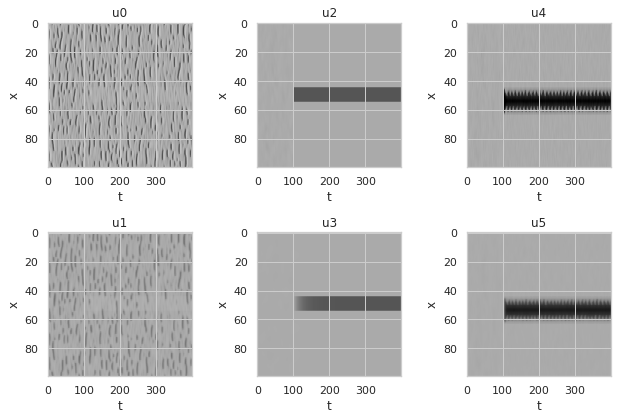

In [ ]:
uplot(u)

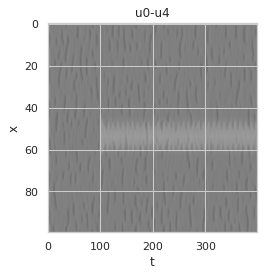

In [ ]:
muscle_contraction_plot(u)

In [ ]:
print('Hello')

Hello


In [2]:
print('test')

test
